# Exercises

In [72]:
import numpy as np
import scipy
import scipy.stats
import scipy.io
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
from tqdm import tqdm
import seaborn as sns
import pickle
import sys
import os
sys.path.append(os.path.abspath("code"))
from utils import download_data

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False})


## Exercise 1 - simulating place cells
---
Use the code we build to simulate place cells in the lesson.

A - Explore what happens when you change the binning in the definition of the firing rate maps (`space_bins`). Make it coarser or broader. 


B - In the spike train simulations, we add some "baseline" noise, not place-related to the firing. Which variable determines the noise level? Try to experiment with that variable and see what happens to the firing rate maps. What is the best approach to firing rate maps when the noise is high.


C - We could use other approaches to firing rate maps: for example make the binning very small (down to 1 cm, which is the resolution of our "video" data, and then applying a gaussian smoother. Scipy has a Gaussian smoother at `scipy.stats.gaussian_kde`. Read the documentation for that function and apply it to the data to define the smoothed firing rate maps. Again, change the noise levels and see how the smoother changes. 

D - When analyzing place fields, two important quantities are the place field center and the place field width. The place field center may be defined in many ways, but one is to compute the "center of mass" of the spikes according to the equation 

$$ c_{pf} = \frac{1}{N_{spikes}} \sum_{i} L_i $$ 

where the sum on $i$ runs on all spikes emitted by a cell and $L_i$ is the location at which the i-th spike was emitted. Calculate this for each cell. Compare with the "true" place field centers from the simulations (which variables are we talking about?) 


### A ###

In [73]:
track_length = 200. # the length of our linear track (eg in centimeter)
average_firing_rate = 5 # the peak firing rate, averaged across the population 
n_cells = 100 # how many cells we are recording
pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

Text(0, 0.5, 'Probability')

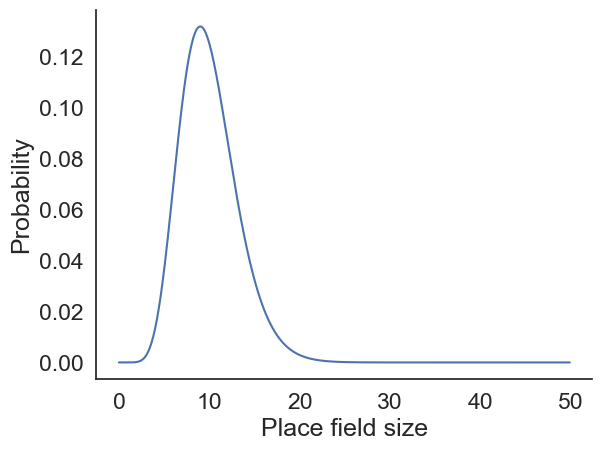

In [74]:
x = np.arange(0., 50., 0.1) # we use a grid with step 0.1
g = scipy.stats.gamma.pdf(x, 10)
plt.plot(x, g)
plt.xlabel('Place field size')
plt.ylabel('Probability')

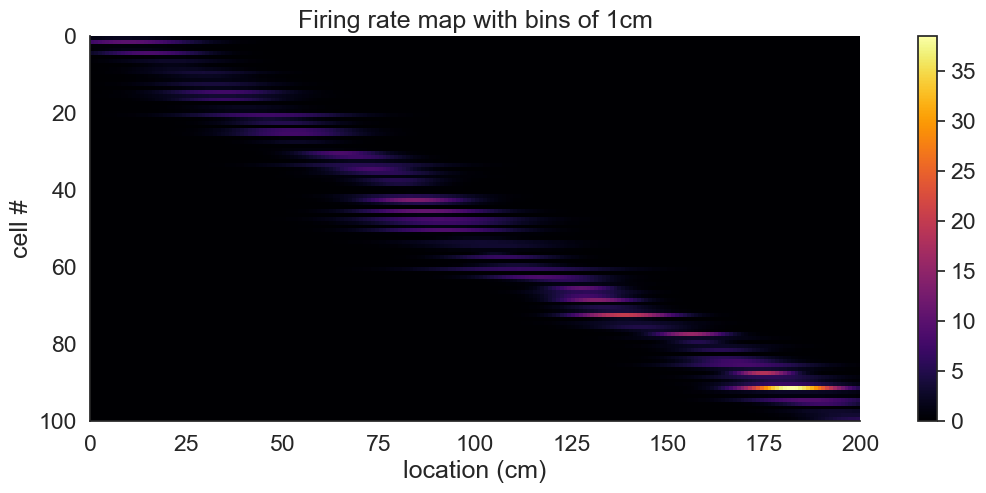

In [75]:
bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))
plt.figure(figsize=(15,5))
ix = np.argsort(pf_centers)
plt.imshow(true_firing_rate_maps[ix,:], cmap='inferno', extent=[0, 200, n_cells, 0])
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.title('Firing rate map with bins of 1cm')
plt.colorbar()
plt.show()

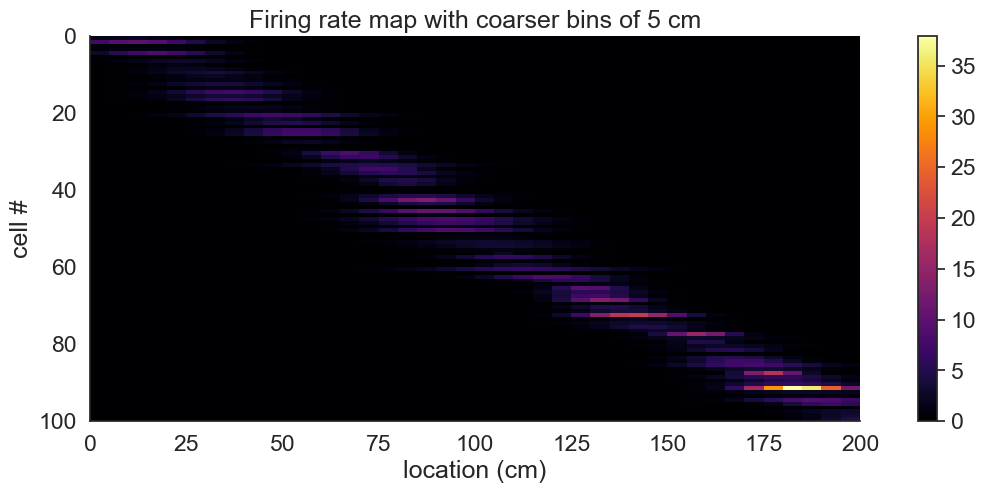

In [76]:
bins = np.arange(0., 200.,5)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))
plt.figure(figsize=(15,5))
ix = np.argsort(pf_centers)
plt.imshow(true_firing_rate_maps[ix,:], cmap='inferno', extent=[0, 200, n_cells, 0])
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.title('Firing rate map with coarser bins of 5 cm')
plt.colorbar()
plt.show()

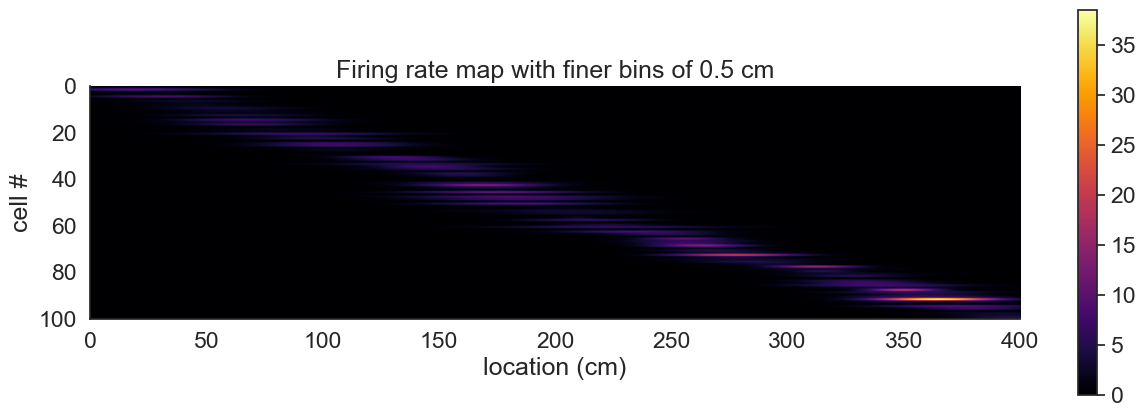

In [77]:
bins = np.arange(0, 200., 0.5)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))
plt.figure(figsize=(15,5))
ix = np.argsort(pf_centers)
plt.imshow(true_firing_rate_maps[ix,:], cmap='inferno', extent=[0, 400, n_cells, 0])
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.title('Firing rate map with finer bins of 0.5 cm')
plt.colorbar()
plt.show()

### B ###

In [78]:
n_runs = 20 
av_running_speed = 10 # the average running speed (in cm/s)
fps = 30 # the number of "video frames" per second 
running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs) 

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)
bins = np.arange(0., 200.)

x = np.array([])
for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    x = np.concatenate((x, stop1, run1, stop2, run2))
t = np.arange(len(x))/fps

Text(0, 0.5, 'position on track (cm)')

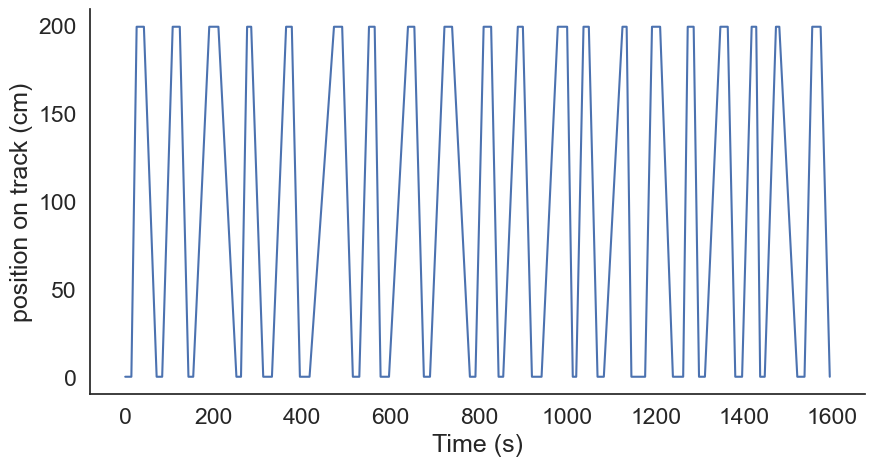

In [79]:
plt.figure(figsize=(10,5))
plt.plot(t, x)
plt.xlabel('Time (s)')
plt.ylabel('position on track (cm)')

In [80]:
sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = 0.8 # the baseline noise firing rate
spikes = []

for i in tqdm(range(n_cells)):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)

100%|██████████| 100/100 [00:44<00:00,  2.25it/s]


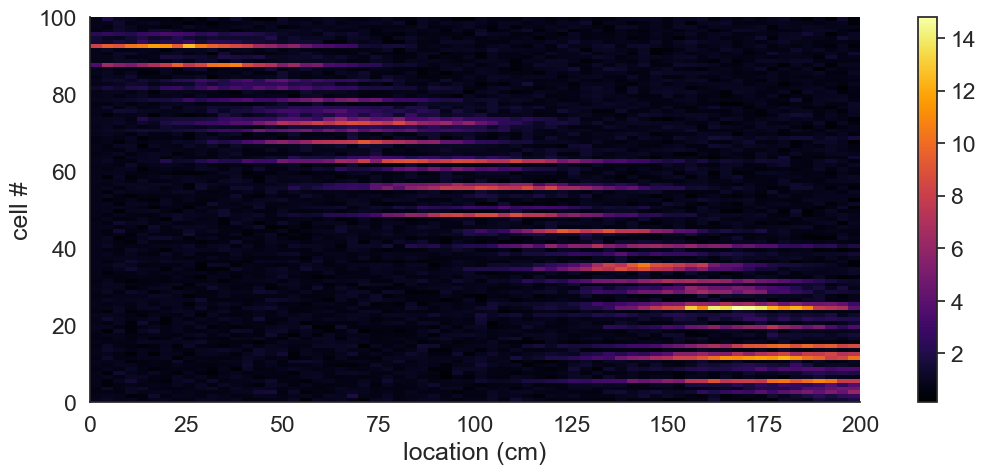

In [81]:
spike_positions = [np.interp(s, t, x) for s in spikes]
space_bins = np.arange(0., 200., 3)

# we compute histograms for eaxh cell
spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]

# put them together into a matrix of floating point numbers (for plotting)
spikes_hist = np.vstack(spikes_hist).astype(np.float64)

# we also need an "occupancy histogram" in order to normalize the firing rates maps 
occupancy = np.histogram(x, space_bins)[0] /  fps

firing_rate_maps = spikes_hist / occupancy 
plt.figure(figsize=(15,5))
peak_locations = firing_rate_maps.argmax(axis=1)
ix = np.argsort(peak_locations)
plt.imshow(firing_rate_maps[ix,:], cmap='inferno', extent = [0, 200, 0, n_cells])
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.colorbar()
plt.show()

the variable for the noise is noise_firing_rate. The best approach to firing rate maps when the noise is high is to increase the bin size. Using this approach, the noise is averaged out and the firing rate maps are more accurate.

### C ###

In [82]:
sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = 0.8 # the baseline noise firing rate
spikes = []

for i in tqdm(range(n_cells)):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)


100%|██████████| 100/100 [00:43<00:00,  2.30it/s]


<Figure size 1500x500 with 0 Axes>

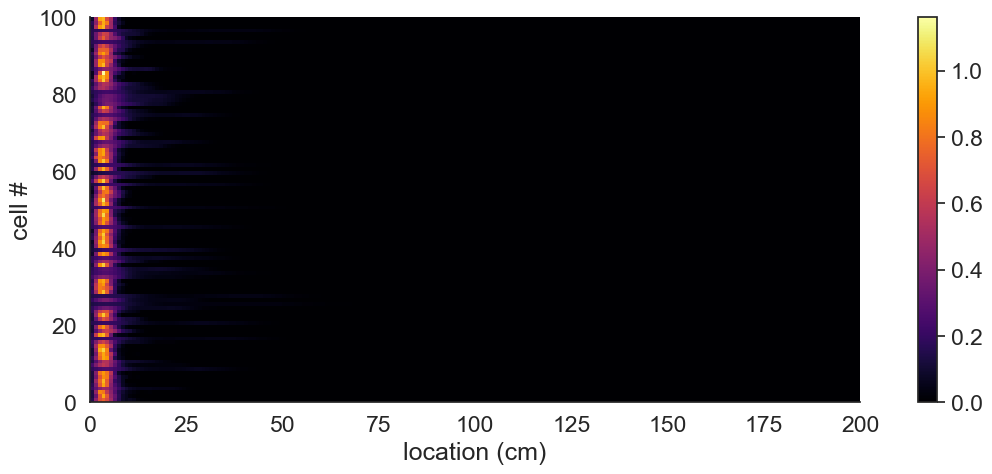

In [83]:

spike_positions = [np.interp(s, t, x) for s in spikes]
space_bins = np.arange(0., 200., 1)

# we compute histograms for eaxh cell
spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]

# put them together into a matrix of floating point numbers (for plotting)
spikes_hist = np.vstack(spikes_hist).astype(np.float64)

# we also need an "occupancy histogram" in order to normalize the firing rates maps 
occupancy = np.histogram(x, space_bins)[0] /  fps

firing_rate_maps = spikes_hist / occupancy 
plt.figure(figsize=(15,5))
peak_locations = firing_rate_maps.argmax(axis=1)
ix = np.argsort(peak_locations)
# Create KDE object for each cell (assuming firing_rate_maps.shape[1] is the number of bins)
kde_maps = []
for i in range(firing_rate_maps.shape[0]):
  kde = scipy.stats.gaussian_kde(firing_rate_maps[i, :])
  kde_maps.append(kde)

# Define positions for evaluation (adjust resolution as needed)
positions = np.linspace(0, 50, 200)  # 200 positions for smoother visualization

# Evaluate KDE at positions for each cell
smoothed_maps = np.zeros((firing_rate_maps.shape[0], len(positions)))
for i, kde in enumerate(kde_maps):
  smoothed_maps[i, :] = kde(positions) 

# Plot the smoothed firing rate maps using imshow
plt.figure(figsize=(15, 5))
plt.imshow(smoothed_maps[ix, :], cmap='inferno', extent=[0, 200, 0, n_cells])
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.colorbar()
plt.show()

### D ###

In [84]:
track_length = 200. # the length of our linear track (eg in centimeter)
average_firing_rate = 5 # the peak firing rate, averaged across the population 
n_cells = 100 # how many cells we are recording
pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

Text(0, 0.5, 'Probability')

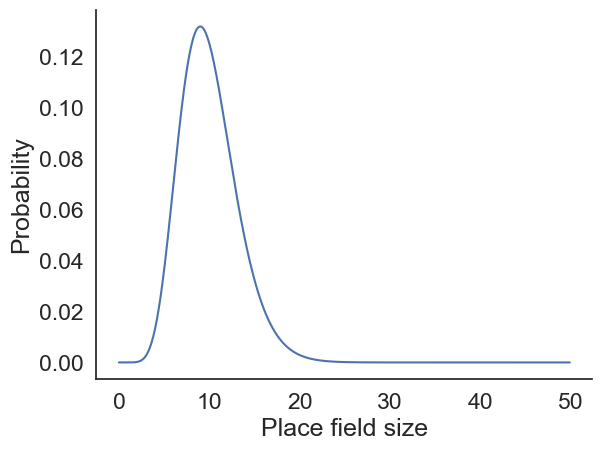

In [85]:
x = np.arange(0., 50., 0.1) # we use a grid with step 0.1
g = scipy.stats.gamma.pdf(x, 10)
plt.plot(x, g)
plt.xlabel('Place field size')
plt.ylabel('Probability')

In [86]:
n_runs = 20 
av_running_speed = 10 # the average running speed (in cm/s)
fps = 30 # the number of "video frames" per second 
running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs) 

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)
bins = np.arange(0., 200.)

x = np.array([])
for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    x = np.concatenate((x, stop1, run1, stop2, run2))
t = np.arange(len(x))/fps

sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = 0.1 # the baseline noise firing rate
spikes = []

for i in tqdm(range(n_cells)):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)

100%|██████████| 100/100 [00:42<00:00,  2.34it/s]


In [88]:
c_pf = np.zeros(n_cells)
for i in range(n_cells):
    c_pf[i] = 1 / len(spikes[i]) * np.sum(np.interp(spikes[i], t, x))



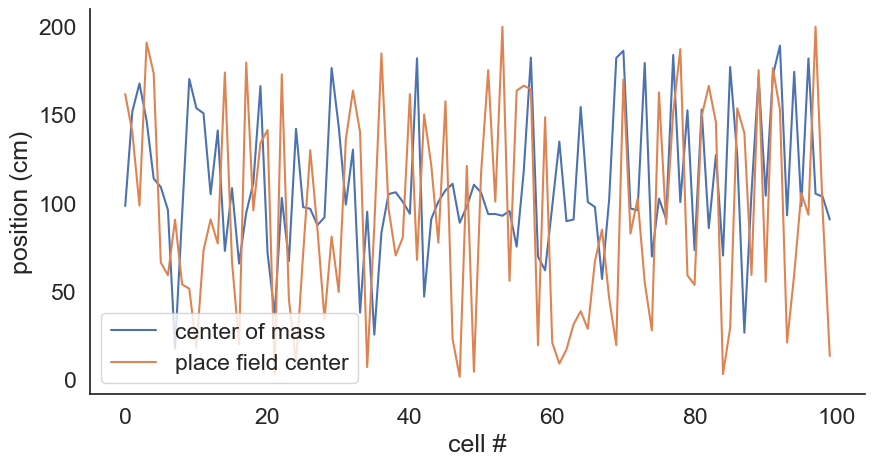

In [89]:
difference = np.abs(c_pf - pf_centers)
plt.figure(figsize=(10,5))
plt.plot(c_pf)
plt.plot(pf_centers)
plt.xlabel('cell #')
plt.ylabel('position (cm)')
plt.legend(['center of mass', 'place field center'])


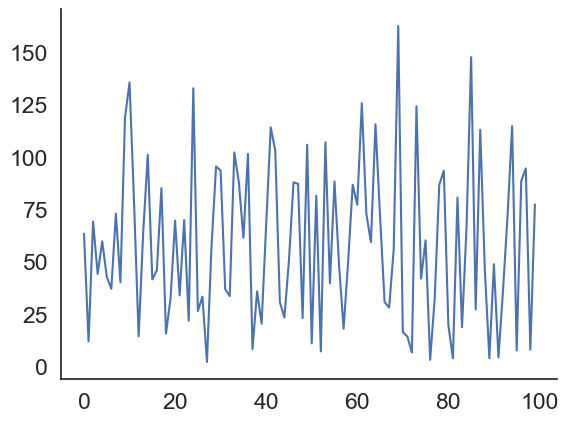

In [90]:
plt.plot(difference)

In [91]:
print(c_pf[10])
print(pf_centers[10])

153.65558656443764
18.059905648106025


## Exercise 2 - mutual information
---
A - Implement the mutual information formula discussed in the lesson, and apply it to the place cell data we simulated.

B - Adapt the simulation so that you can systematically vary 1) Peak firing rate, 2) place cell size 3) baseline noise. 
Study how mutual information vary with these parameters. Use both definition of mutual information above, and discuss the differences between them. Make some plots to show how the dependency goes.

100%|██████████| 100/100 [00:45<00:00,  2.19it/s]


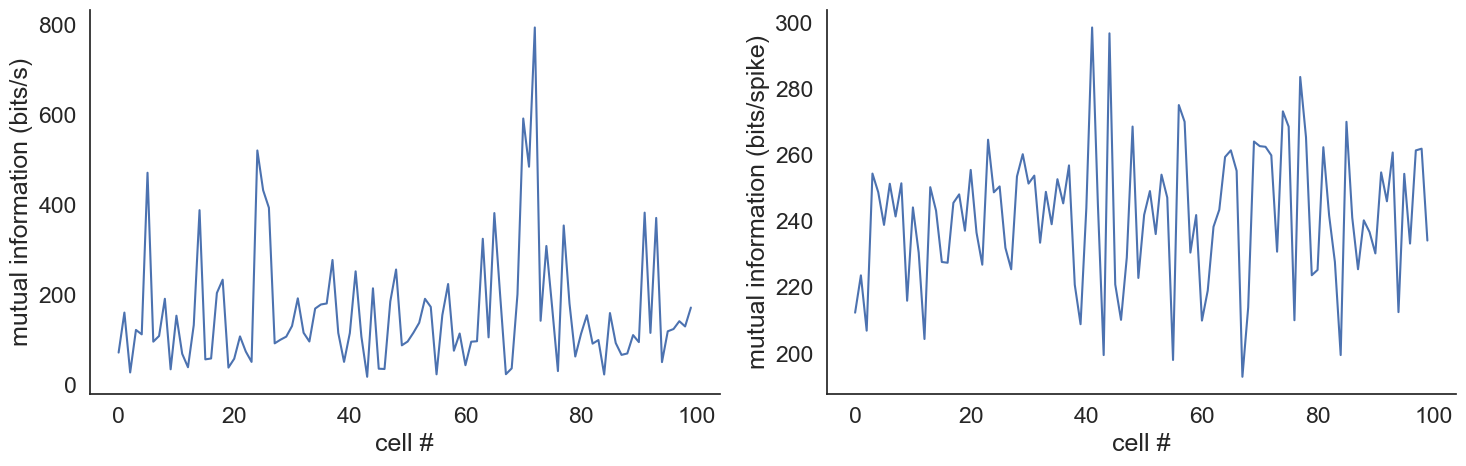

In [92]:
average_firing_rate = 5 # the peak firing rate, averaged across the population 
track_length = 200. # the length of our linear track (eg in centimeter)
place_cell_size = 10 # the size of the place fields
noise_firing_rate = 0.1 # the baseline noise firing rate
n_cells = 100 # how many cells we are recording
pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(place_cell_size, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

x = np.arange(0., 50., 0.1) # we use a grid with step 0.1
g = scipy.stats.gamma.pdf(x, 10)

bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))
n_runs = 20 
av_running_speed = 10 # the average running speed (in cm/s)
fps = 30 # the number of "video frames" per second 
running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs) 

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])
for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    x = np.concatenate((x, stop1, run1, stop2, run2))
t = np.arange(len(x))/fps
sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
spikes = []

for i in tqdm(range(n_cells)):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)
spike_positions = [np.interp(s, t, x) for s in spikes]
space_bins = np.arange(0., 200., 5.)

# we compute histograms for eaxh cell
spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]

# put them together into a matrix of floating point numbers (for plotting)
spikes_hist = np.vstack(spikes_hist).astype(np.float64)

# we also need an "occupancy histogram" in order to normalize the firing rates maps 
occupancy = np.histogram(x, space_bins)[0] /  fps

firing_rate_maps = spikes_hist / occupancy 
epsilon = 1e-15
lambda_x = firing_rate_maps
average_firing_rate = np.mean(lambda_x, axis=1)

mutual_information = np.zeros(n_cells)
mutual_information_spike = np.zeros(n_cells)
for i in range(n_cells):
    p_x = lambda_x[i] * np.log2((lambda_x[i] + epsilon)/(average_firing_rate[i])*occupancy) 
    p_x_spike = p_x / average_firing_rate[i]
    mutual_information[i] = np.sum(p_x)
    mutual_information_spike[i] = np.sum(p_x_spike)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(mutual_information)
plt.xlabel('cell #')
plt.ylabel('mutual information (bits/s)')
plt.subplot(1,2,2)
plt.plot(mutual_information_spike)
plt.xlabel('cell #')
plt.ylabel('mutual information (bits/spike)')
plt.tight_layout()
plt.show()

100%|██████████| 100/100 [00:48<00:00,  2.06it/s]


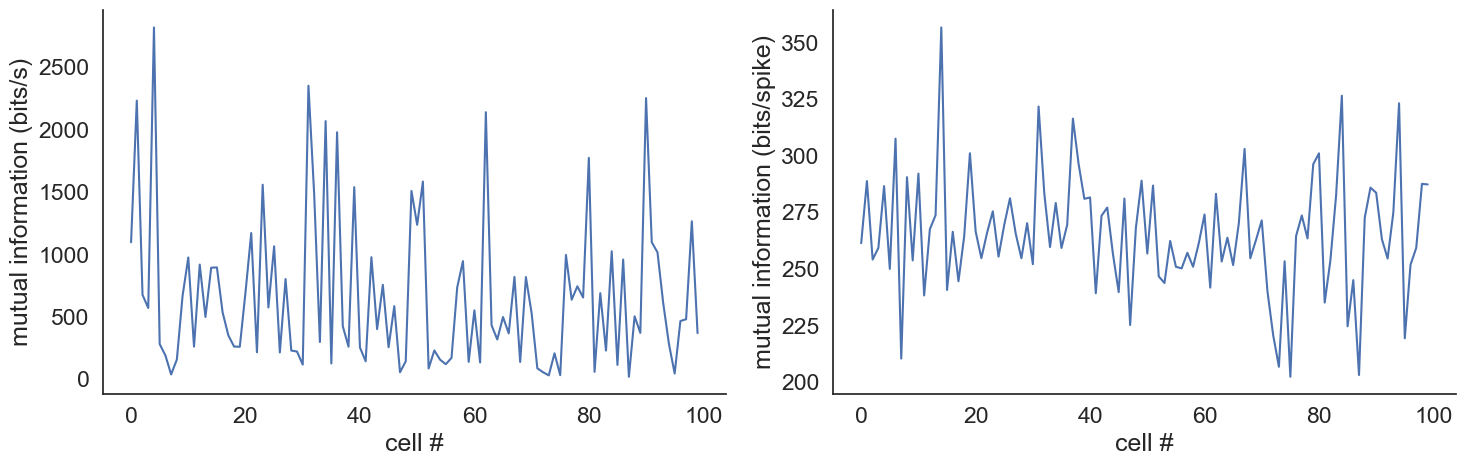

In [93]:
average_firing_rate = 20 # the peak firing rate, averaged across the population 
track_length = 200. # the length of our linear track (eg in centimeter)
place_cell_size = 10 # the size of the place fields
noise_firing_rate = 0.1 # the baseline noise firing rate
n_cells = 100 # how many cells we are recording
pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(place_cell_size, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

x = np.arange(0., 50., 0.1) # we use a grid with step 0.1
g = scipy.stats.gamma.pdf(x, 10)

bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))
n_runs = 20 
av_running_speed = 10 # the average running speed (in cm/s)
fps = 30 # the number of "video frames" per second 
running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs) 

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])
for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    x = np.concatenate((x, stop1, run1, stop2, run2))
t = np.arange(len(x))/fps
sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
spikes = []

for i in tqdm(range(n_cells)):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)
spike_positions = [np.interp(s, t, x) for s in spikes]
space_bins = np.arange(0., 200., 5.)

# we compute histograms for eaxh cell
spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]

# put them together into a matrix of floating point numbers (for plotting)
spikes_hist = np.vstack(spikes_hist).astype(np.float64)

# we also need an "occupancy histogram" in order to normalize the firing rates maps 
occupancy = np.histogram(x, space_bins)[0] /  fps

firing_rate_maps = spikes_hist / occupancy 
epsilon = 1e-15
lambda_x = firing_rate_maps
average_firing_rate = np.mean(lambda_x, axis=1)

mutual_information = np.zeros(n_cells)
mutual_information_spike = np.zeros(n_cells)
for i in range(n_cells):
    p_x = lambda_x[i] * np.log2((lambda_x[i] + epsilon)/(average_firing_rate[i])*occupancy) 
    p_x_spike = p_x / average_firing_rate[i]
    mutual_information[i] = np.sum(p_x)
    mutual_information_spike[i] = np.sum(p_x_spike)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(mutual_information)
plt.xlabel('cell #')
plt.ylabel('mutual information (bits/s)')
plt.subplot(1,2,2)
plt.plot(mutual_information_spike)
plt.xlabel('cell #')
plt.ylabel('mutual information (bits/spike)')
plt.tight_layout()
plt.show()

100%|██████████| 100/100 [00:42<00:00,  2.35it/s]


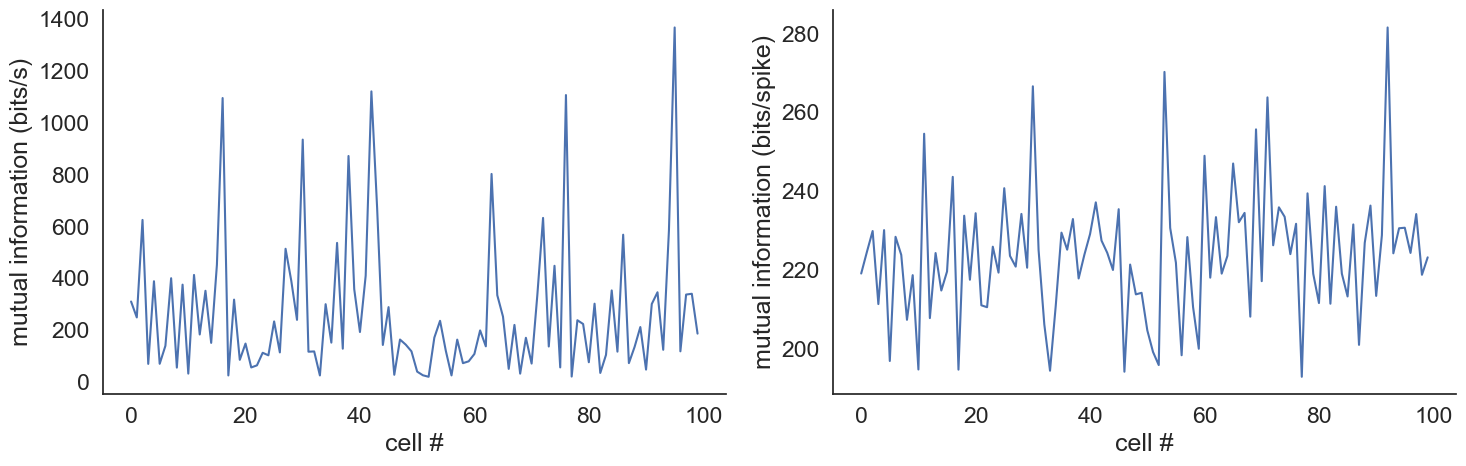

In [94]:
average_firing_rate = 5 # the peak firing rate, averaged across the population 
track_length = 200. # the length of our linear track (eg in centimeter)
place_cell_size = 20 # the size of the place fields
noise_firing_rate = 0.1 # the baseline noise firing rate
n_cells = 100 # how many cells we are recording
pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(place_cell_size, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

x = np.arange(0., 50., 0.1) # we use a grid with step 0.1
g = scipy.stats.gamma.pdf(x, 10)

bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))
n_runs = 20 
av_running_speed = 10 # the average running speed (in cm/s)
fps = 30 # the number of "video frames" per second 
running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs) 

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])
for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    x = np.concatenate((x, stop1, run1, stop2, run2))
t = np.arange(len(x))/fps
sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
spikes = []

for i in tqdm(range(n_cells)):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)
spike_positions = [np.interp(s, t, x) for s in spikes]
space_bins = np.arange(0., 200., 5.)

# we compute histograms for eaxh cell
spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]

# put them together into a matrix of floating point numbers (for plotting)
spikes_hist = np.vstack(spikes_hist).astype(np.float64)

# we also need an "occupancy histogram" in order to normalize the firing rates maps 
occupancy = np.histogram(x, space_bins)[0] /  fps

firing_rate_maps = spikes_hist / occupancy 
epsilon = 1e-15
lambda_x = firing_rate_maps
average_firing_rate = np.mean(lambda_x, axis=1)

mutual_information = np.zeros(n_cells)
mutual_information_spike = np.zeros(n_cells)
for i in range(n_cells):
    p_x = lambda_x[i] * np.log2((lambda_x[i] + epsilon)/(average_firing_rate[i])*occupancy) 
    p_x_spike = p_x / average_firing_rate[i]
    mutual_information[i] = np.sum(p_x)
    mutual_information_spike[i] = np.sum(p_x_spike)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(mutual_information)
plt.xlabel('cell #')
plt.ylabel('mutual information (bits/s)')
plt.subplot(1,2,2)
plt.plot(mutual_information_spike)
plt.xlabel('cell #')
plt.ylabel('mutual information (bits/spike)')
plt.tight_layout()
plt.show()

100%|██████████| 100/100 [00:44<00:00,  2.27it/s]


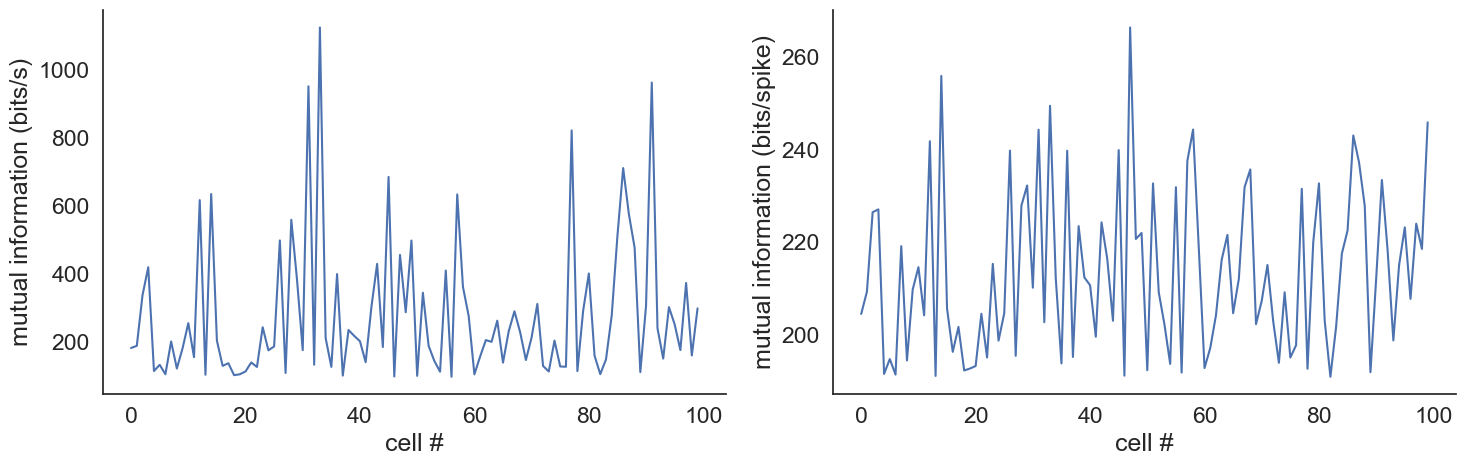

In [95]:
average_firing_rate = 5 # the peak firing rate, averaged across the population 
track_length = 200. # the length of our linear track (eg in centimeter)
place_cell_size = 10 # the size of the place fields
noise_firing_rate = 0.5 # the baseline noise firing rate
n_cells = 100 # how many cells we are recording
pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(place_cell_size, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

x = np.arange(0., 50., 0.1) # we use a grid with step 0.1
g = scipy.stats.gamma.pdf(x, 10)

bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))
n_runs = 20 
av_running_speed = 10 # the average running speed (in cm/s)
fps = 30 # the number of "video frames" per second 
running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs) 

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])
for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    x = np.concatenate((x, stop1, run1, stop2, run2))
t = np.arange(len(x))/fps
sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
spikes = []

for i in tqdm(range(n_cells)):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)
spike_positions = [np.interp(s, t, x) for s in spikes]
space_bins = np.arange(0., 200., 5.)

# we compute histograms for eaxh cell
spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]

# put them together into a matrix of floating point numbers (for plotting)
spikes_hist = np.vstack(spikes_hist).astype(np.float64)

# we also need an "occupancy histogram" in order to normalize the firing rates maps 
occupancy = np.histogram(x, space_bins)[0] /  fps

firing_rate_maps = spikes_hist / occupancy 
epsilon = 1e-15
lambda_x = firing_rate_maps
average_firing_rate = np.mean(lambda_x, axis=1)

mutual_information = np.zeros(n_cells)
mutual_information_spike = np.zeros(n_cells)
for i in range(n_cells):
    p_x = lambda_x[i] * np.log2((lambda_x[i] + epsilon)/(average_firing_rate[i])*occupancy) 
    p_x_spike = p_x / average_firing_rate[i]
    mutual_information[i] = np.sum(p_x)
    mutual_information_spike[i] = np.sum(p_x_spike)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(mutual_information)
plt.xlabel('cell #')
plt.ylabel('mutual information (bits/s)')
plt.subplot(1,2,2)
plt.plot(mutual_information_spike)
plt.xlabel('cell #')
plt.ylabel('mutual information (bits/spike)')
plt.tight_layout()
plt.show()

100%|██████████| 100/100 [00:39<00:00,  2.55it/s]


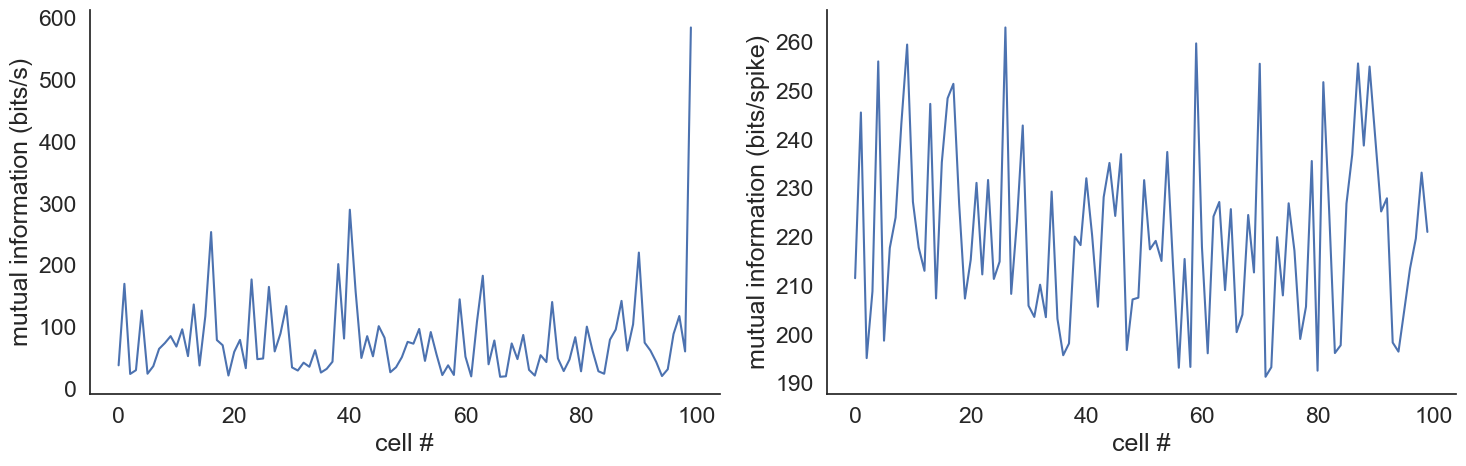

In [96]:
average_firing_rate = 2 # the peak firing rate, averaged across the population 
track_length = 200. # the length of our linear track (eg in centimeter)
place_cell_size = 10 # the size of the place fields
noise_firing_rate = 0.1 # the baseline noise firing rate
n_cells = 100 # how many cells we are recording
pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(place_cell_size, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

x = np.arange(0., 50., 0.1) # we use a grid with step 0.1
g = scipy.stats.gamma.pdf(x, 10)

bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))
n_runs = 20 
av_running_speed = 10 # the average running speed (in cm/s)
fps = 30 # the number of "video frames" per second 
running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs) 

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])
for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    x = np.concatenate((x, stop1, run1, stop2, run2))
t = np.arange(len(x))/fps
sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
spikes = []

for i in tqdm(range(n_cells)):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)
spike_positions = [np.interp(s, t, x) for s in spikes]
space_bins = np.arange(0., 200., 5.)

# we compute histograms for eaxh cell
spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]

# put them together into a matrix of floating point numbers (for plotting)
spikes_hist = np.vstack(spikes_hist).astype(np.float64)

# we also need an "occupancy histogram" in order to normalize the firing rates maps 
occupancy = np.histogram(x, space_bins)[0] /  fps

firing_rate_maps = spikes_hist / occupancy 
epsilon = 1e-15
lambda_x = firing_rate_maps
average_firing_rate = np.mean(lambda_x, axis=1)

mutual_information = np.zeros(n_cells)
mutual_information_spike = np.zeros(n_cells)
for i in range(n_cells):
    p_x = lambda_x[i] * np.log2((lambda_x[i] + epsilon)/(average_firing_rate[i])*occupancy) 
    p_x_spike = p_x / average_firing_rate[i]
    mutual_information[i] = np.sum(p_x)
    mutual_information_spike[i] = np.sum(p_x_spike)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(mutual_information)
plt.xlabel('cell #')
plt.ylabel('mutual information (bits/s)')
plt.subplot(1,2,2)
plt.plot(mutual_information_spike)
plt.xlabel('cell #')
plt.ylabel('mutual information (bits/spike)')
plt.tight_layout()
plt.show()

100%|██████████| 100/100 [00:42<00:00,  2.34it/s]


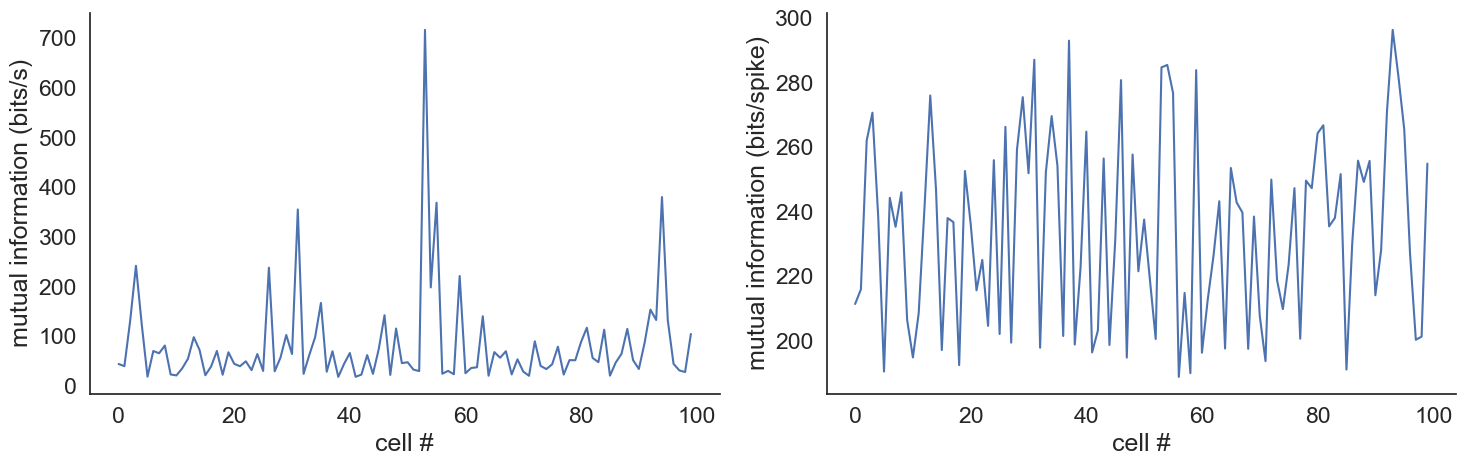

In [97]:
average_firing_rate = 5 # the peak firing rate, averaged across the population 
track_length = 200. # the length of our linear track (eg in centimeter)
place_cell_size = 4 # the size of the place fields
noise_firing_rate = 0.1 # the baseline noise firing rate
n_cells = 100 # how many cells we are recording
pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(place_cell_size, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

x = np.arange(0., 50., 0.1) # we use a grid with step 0.1
g = scipy.stats.gamma.pdf(x, 10)

bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))
n_runs = 20 
av_running_speed = 10 # the average running speed (in cm/s)
fps = 30 # the number of "video frames" per second 
running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs) 

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])
for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    x = np.concatenate((x, stop1, run1, stop2, run2))
t = np.arange(len(x))/fps
sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
spikes = []

for i in tqdm(range(n_cells)):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)
spike_positions = [np.interp(s, t, x) for s in spikes]
space_bins = np.arange(0., 200., 5.)

# we compute histograms for eaxh cell
spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]

# put them together into a matrix of floating point numbers (for plotting)
spikes_hist = np.vstack(spikes_hist).astype(np.float64)

# we also need an "occupancy histogram" in order to normalize the firing rates maps 
occupancy = np.histogram(x, space_bins)[0] /  fps

firing_rate_maps = spikes_hist / occupancy 
epsilon = 1e-15
lambda_x = firing_rate_maps
average_firing_rate = np.mean(lambda_x, axis=1)

mutual_information = np.zeros(n_cells)
mutual_information_spike = np.zeros(n_cells)
for i in range(n_cells):
    p_x = lambda_x[i] * np.log2((lambda_x[i] + epsilon)/(average_firing_rate[i])*occupancy) 
    p_x_spike = p_x / average_firing_rate[i]
    mutual_information[i] = np.sum(p_x)
    mutual_information_spike[i] = np.sum(p_x_spike)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(mutual_information)
plt.xlabel('cell #')
plt.ylabel('mutual information (bits/s)')
plt.subplot(1,2,2)
plt.plot(mutual_information_spike)
plt.xlabel('cell #')
plt.ylabel('mutual information (bits/spike)')
plt.tight_layout()
plt.show()

100%|██████████| 100/100 [00:45<00:00,  2.21it/s]


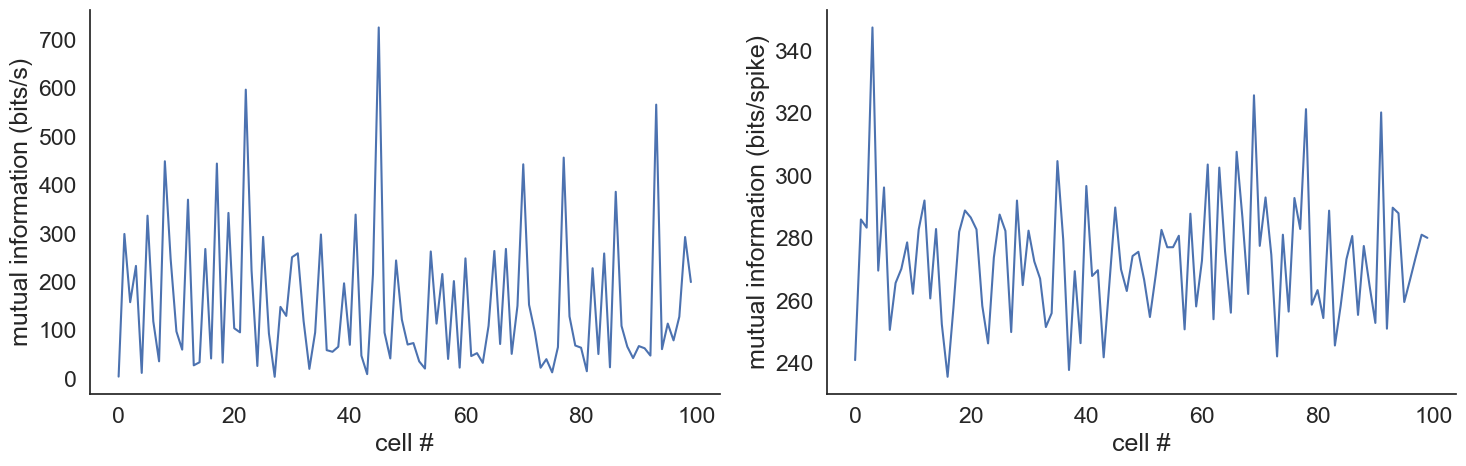

In [98]:
average_firing_rate = 5 # the peak firing rate, averaged across the population 
track_length = 200. # the length of our linear track (eg in centimeter)
place_cell_size = 10 # the size of the place fields
noise_firing_rate = 0.02 # the baseline noise firing rate
n_cells = 100 # how many cells we are recording
pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(place_cell_size, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution

x = np.arange(0., 50., 0.1) # we use a grid with step 0.1
g = scipy.stats.gamma.pdf(x, 10)

bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))
n_runs = 20 
av_running_speed = 10 # the average running speed (in cm/s)
fps = 30 # the number of "video frames" per second 
running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs) 

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])
for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    x = np.concatenate((x, stop1, run1, stop2, run2))
t = np.arange(len(x))/fps
sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
spikes = []

for i in tqdm(range(n_cells)):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp)
spike_positions = [np.interp(s, t, x) for s in spikes]
space_bins = np.arange(0., 200., 5.)

# we compute histograms for eaxh cell
spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]

# put them together into a matrix of floating point numbers (for plotting)
spikes_hist = np.vstack(spikes_hist).astype(np.float64)

# we also need an "occupancy histogram" in order to normalize the firing rates maps 
occupancy = np.histogram(x, space_bins)[0] /  fps

firing_rate_maps = spikes_hist / occupancy 
epsilon = 1e-15
lambda_x = firing_rate_maps
average_firing_rate = np.mean(lambda_x, axis=1)

mutual_information = np.zeros(n_cells)
mutual_information_spike = np.zeros(n_cells)
for i in range(n_cells):
    p_x = lambda_x[i] * np.log2((lambda_x[i] + epsilon)/(average_firing_rate[i])*occupancy) 
    p_x_spike = p_x / average_firing_rate[i]
    mutual_information[i] = np.sum(p_x)
    mutual_information_spike[i] = np.sum(p_x_spike)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(mutual_information)
plt.xlabel('cell #')
plt.ylabel('mutual information (bits/s)')
plt.subplot(1,2,2)
plt.plot(mutual_information_spike)
plt.xlabel('cell #')
plt.ylabel('mutual information (bits/spike)')
plt.tight_layout()
plt.show()

The mutual information is a measure of how much information about the position of the animal is contained in the spike train of the cell. We have two different definitions of mutual information. The first one is expressed in bits per second, and the second one is expressed in bits per spike. The first one is more useful when we are interested in the information content of the spike train, while the second one is more useful when we are interested in the information content of a single spike. Varying the peak firing rate, the place cell size, and the baseline noise will affect the mutual information. The mutual information will increase with the peak firing rate and decrease with the place cell size, and the baseline noise.

## Exercise 3 - working with real data
---
Load the data from `linear_track_data.pickle`. It contains neural recordings from a mouse running on a linear track.
- `x` contains the position of the animal
- `t` contains the corresponding times, in seconds
- `spikes` contains a list of lists. Each list contains the timestamps of the spikes emitted by a neuron.

A - Visualiaze the position a s a function of time. Plot the spike of a selected cell in space.

B - Calculate the firing rate maps for all the cells, and plot them sorted by increasing peak positon.

C - Calculate the spatial information for each cell, and plot the distribution. Plot the firing rate maps of the 5 cells with lower spatial information, and the firing rate maps of the 5 cells with higher spatial information. Comment on the differences.

### A ###

In [99]:
data = np.load('data/linear_track_data.pickle', allow_pickle=True)

In [100]:
print(data.keys())
x = data['x']
t = data['t']
spikes = data['spikes']
print(len(spikes))
print(np.max(x))

dict_keys(['x', 't', 'spikes'])
72
94.96118975101513


In [101]:
n_cells = len(spikes)
def plot_unit(i):
    plt.figure(figsize=(10,5))
    plt.plot(t, x)
    plt.plot(spikes[i], np.interp(spikes[i], t, x), 'r.')
    plt.xlabel('Time (s)')
    plt.ylabel('position on track (cm)')
    
interact(plot_unit, i = widgets.IntSlider(min=0, max=(n_cells-1), value=0))

interactive(children=(IntSlider(value=0, description='i', max=71), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_unit(i)>

### B ###

In [102]:
spike_positions = [np.interp(s, t, x) for s in spikes]

In [103]:
max_position = 95
space_bins = np.arange(0., max_position, 5.)

# we compute histograms for eaxh cell
spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]

# put them together into a matrix of floating point numbers (for plotting)
spikes_hist = np.vstack(spikes_hist).astype(np.float64)

# we also need an "occupancy histogram" in order to normalize the firing rates maps
fps = 30 
occupancy = np.histogram(x, space_bins)[0] /  fps

firing_rate_maps = spikes_hist / occupancy 

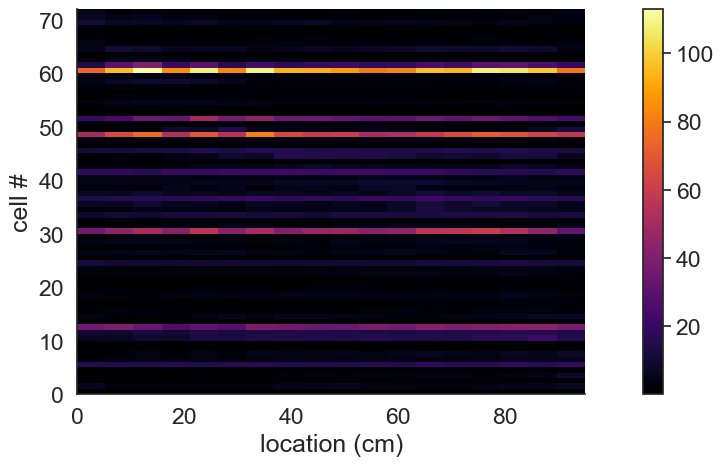

In [104]:
plt.figure(figsize=(15,5))
peak_locations = firing_rate_maps.argmax(axis=1)
ix = np.argsort(peak_locations)
plt.imshow(firing_rate_maps[ix,:], cmap='inferno', extent = [0, max_position, 0, n_cells])
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.colorbar()

### C ###

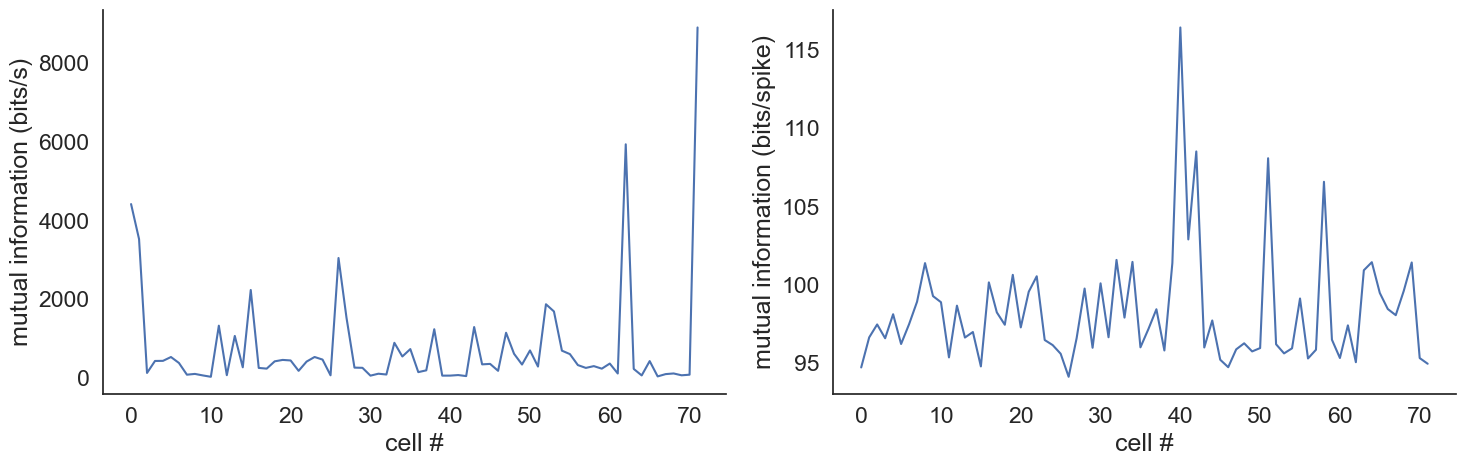

In [105]:

epsilon = 1e-15
lambda_x = firing_rate_maps
average_firing_rate = np.mean(lambda_x, axis=1)

mutual_information = np.zeros(n_cells)
mutual_information_spike = np.zeros(n_cells)
for i in range(n_cells):
    p_x = lambda_x[i] * np.log2((lambda_x[i] + epsilon)/(average_firing_rate[i])*occupancy) 
    p_x_spike = p_x / average_firing_rate[i]
    mutual_information[i] = np.sum(p_x)
    mutual_information_spike[i] = np.sum(p_x_spike)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(mutual_information)
plt.xlabel('cell #')
plt.ylabel('mutual information (bits/s)')
plt.subplot(1,2,2)
plt.plot(mutual_information_spike)
plt.xlabel('cell #')
plt.ylabel('mutual information (bits/spike)')
plt.tight_layout()
plt.show()

[41 58 51 42 40]
[102.90389208 106.58738899 108.09195123 108.52614752 116.44886199]
[26  0 46 15 71]
[94.12593196 94.72225833 94.73817782 94.78947728 94.95867973]


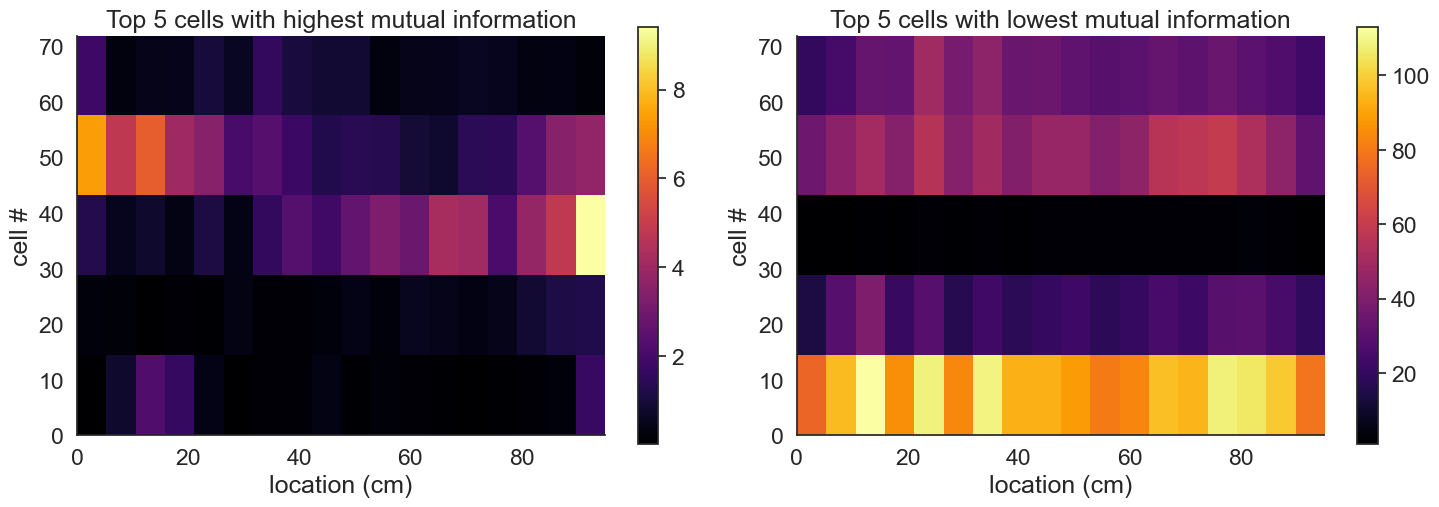

In [106]:
max_5 = np.argsort(mutual_information_spike)[-5:]
print(max_5)
print(mutual_information_spike[max_5])
min_5 = np.argsort(mutual_information_spike)[:5]
print(min_5)
print(mutual_information_spike[min_5])
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
ix = max_5
plt.imshow(firing_rate_maps[max_5], cmap='inferno', extent = [0, max_position, 0, n_cells])
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.title('Top 5 cells with highest mutual information')
plt.colorbar()
plt.subplot(1,2,2)
ix = min_5
plt.imshow(firing_rate_maps[min_5], cmap='inferno', extent = [0, max_position, 0, n_cells])
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.title('Top 5 cells with lowest mutual information')
plt.colorbar()
plt.tight_layout()
plt.show()

For the cells with the highest spatial information, the firing rate maps have a clearer peak and the peak firing rate is lower. For the cells with the lowest spatial information, the firing rate maps are more uniform and the peak firing rate is higher.